<a href="https://colab.research.google.com/github/gogooma9/SolarGen/blob/rf/src/solar_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
warnings.filterwarnings("ignore")

data_path = '/content/drive/MyDrive/SolarGen/'

## Baseline

In [ ]:
train = pd.read_csv(data_path + './data/train/train.csv')
submission = pd.read_csv(data_path + './data/sample_submission.csv')

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
import scipy.interpolate as interpolate


def LOF(data, neighbors = 20 ,conta =0.01):
    temp = data.copy()
    temp = temp[['DHI', 'DNI']]

    clf = LocalOutlierFactor(n_neighbors = neighbors, contamination = conta , p = 2)
    y_pred = clf.fit_predict(temp)

    return y_pred

#p = 1 or 2
#neighbors
#conta
#number of variables

train_afterLOF = pd.DataFrame(LOF(train, 20, 0.005))

outlier_idx = train_afterLOF[train_afterLOF[0] < 1].index
print(len(outlier_idx))

train.drop(outlier_idx, axis=0, inplace=True)

new_idx = [i for i in range(0,52560)]
added_idx_train = train.reindex(new_idx)
train = added_idx_train.interpolate(method = 'linear',limit_direction='forward')
train

263


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.5,69.08,-12.0,0.0
1,0.0,0.0,30.0,0.0,0.0,1.5,69.06,-12.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.6,71.78,-12.0,0.0
3,0.0,1.0,30.0,0.0,0.0,1.6,71.75,-12.0,0.0
4,0.0,2.0,0.0,0.0,0.0,1.6,75.20,-12.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094.0,21.0,30.0,0.0,0.0,2.4,70.70,-4.0,0.0
52556,1094.0,22.0,0.0,0.0,0.0,2.4,66.79,-4.0,0.0
52557,1094.0,22.0,30.0,0.0,0.0,2.2,66.78,-4.0,0.0
52558,1094.0,23.0,0.0,0.0,0.0,2.1,67.72,-4.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1937897908>,
      dtype=object)

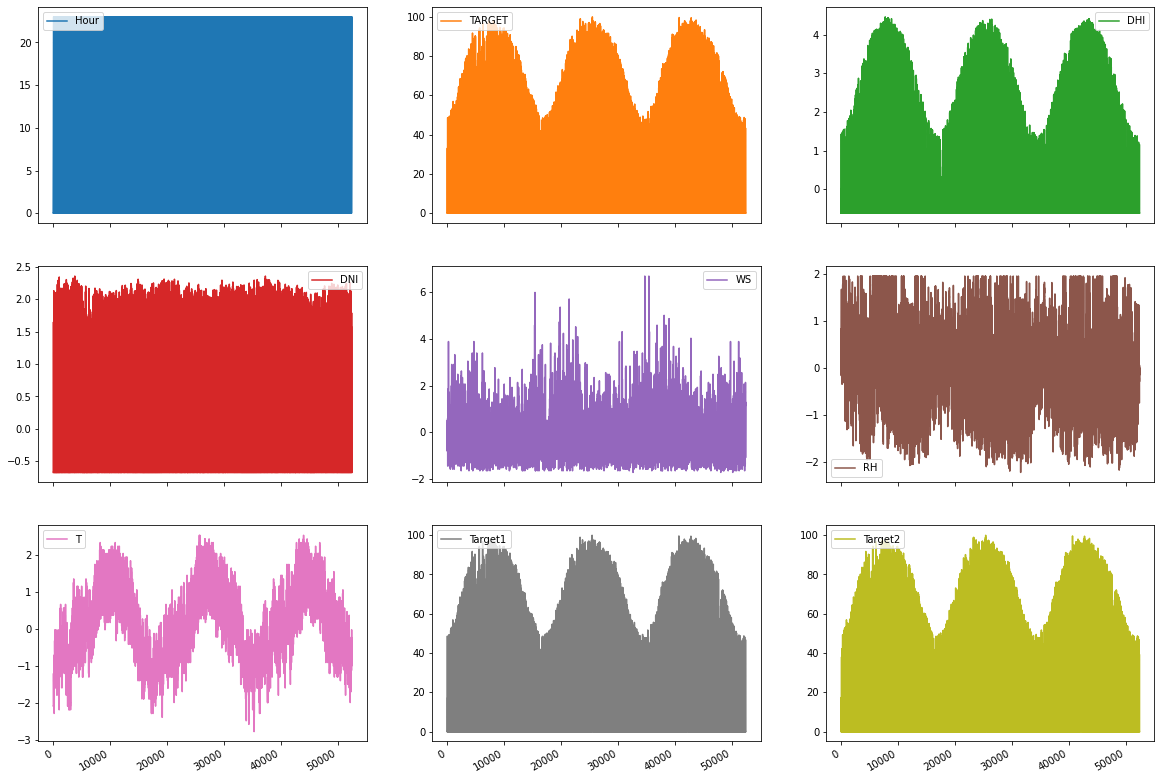

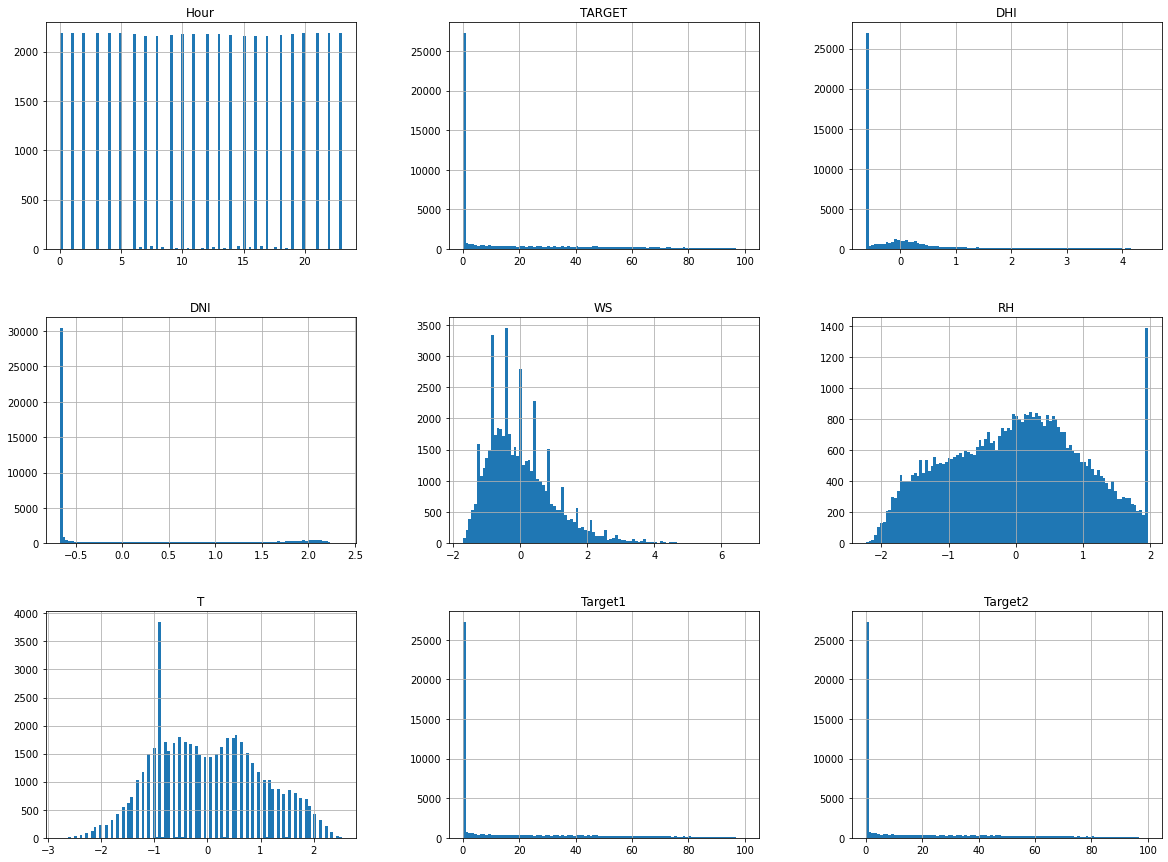

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, 
    MaxAbsScaler, PowerTransformer
)

def scaling(data, scaler, is_train=True):

    temp = data.copy()

    target_cols = ['DHI', 'DNI', 'WS', 'RH', 'T']
    temp = temp[target_cols]
    if is_train: 
        scaler.fit(temp)
    scaled = scaler.transform(temp)

    data[target_cols] = scaled

    return data     

def preprocess_data(data, scalers, is_train=True):
    
    temp = data.copy()

    for scaler in scalers:
        temp = scaling(temp, scaler, is_train)

    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

scalers = []
scalers.append(MinMaxScaler())
scalers.append(StandardScaler())
# scalers.append(RobustScaler())
# scalers.append(MaxAbsScaler())
# scalers.append(QuantileTransformer(n_quantiles=900))
# scalers.append(PowerTransformer(method='yeo-johnson'))
# scalers.append(PowerTransformer(method='box-cox'))

df_train = preprocess_data(train, scalers)
df_train.plot(subplots=True, layout=(3,3), figsize=(20,15))
df_train.hist(bins = 100, figsize=(20,15))

In [ ]:
df_test = []

for i in range(81):
    file_path = data_path + './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, scalers, is_train=False)
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

In [ ]:
from sklearn.model_selection import train_test_split
X_train_1, Y_train_1 = df_train.iloc[:, :-2], df_train.iloc[:, -2]
X_train_2, Y_train_2 = df_train.iloc[:, :-2], df_train.iloc[:, -1]

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def fr_model_score(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={'max_depth': range(3,4), 'n_estimators': (500,1000)},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rf = RandomForestRegressor(max_depth=best_params["max_depth"], 
                               n_estimators=best_params["n_estimators"], 
                               random_state=0, verbose=True, n_jobs=-1, max_features = 'auto')

# Perform K-Fold CV
    scores = cross_val_score(rf, X, y, cv=5, scoring='neg_mean_absolute_error')

    return scores


In [ ]:
fr_model_score(X_train_1, Y_train_1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 

array([-7.8278006 , -4.9572039 , -8.59549516, -5.51805623, -6.98083417])

In [ ]:
fr_model_score(X_train_2, Y_train_2)

In [ ]:
def fr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={'max_depth': range(3,4), 'n_estimators': (500,1000)},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rf = RandomForestRegressor(max_depth=best_params["max_depth"], 
                               n_estimators=best_params["n_estimators"], 
                               random_state=0, verbose=True, n_jobs=-1, max_features = 'auto')
    rf.fit(X,y)

    pred_Q = pd.DataFrame()
    for pred in rf.estimators_:
        temp = pd.Series(pred.predict(X_test).round(2))
        pred_Q = pd.concat([pred_Q,temp],axis=1)
    
    return rf, pred_Q



In [ ]:
def train_data(X_train, Y_train):
    RF_actual_pred = pd.DataFrame()

    rf, pred_Q = fr_model(X_train, Y_train)

    for q in quantiles:
        s = pred_Q.quantile(q=q, axis=1)
        RF_actual_pred = pd.concat([RF_actual_pred,s],axis=1,sort=False)

    RF_actual_pred.columns=quantiles
    RF_actual_pred = RF_actual_pred.round(2)
    return RF_actual_pred



In [ ]:
results_1 = train_data(X_train_1,Y_train_1)
results_2 = train_data(X_train_2,Y_train_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.7s finished


In [ ]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
1,0.csv_Day7_0h30m,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
2,0.csv_Day7_1h00m,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
3,0.csv_Day7_1h30m,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
4,0.csv_Day7_2h00m,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01
7772,80.csv_Day8_22h00m,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01
7773,80.csv_Day8_22h30m,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01
7774,80.csv_Day8_23h00m,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [ ]:
#submission.to_csv(data_path + './data/submission.csv', index=False)